In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
pt = PrettyTable()
pt.field_names = ["Text Vectorizer Model", "Optimal K-value", "Scoring Metric", "Accuracy", "TPR", "TNR", "FPR", "FNR"]

In [3]:
%%time
con = sqlite3.connect('database.sqlite')
raw_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
raw_data = raw_data.sort_values('Time')
print(raw_data.shape)

(525814, 10)
Wall time: 12.6 s


In [4]:
def preprocess(data):
    '''
    Preprocess I/P data :-
    1. Update Score with 0 (-ve Review) and 1 (+ve Review).
    2. Add another feature with Review length.
    3. Select unique rows based on - UserId, ProfileName, Time and Text.
    4. Remove rows which have helpfulness denominator greater than helpfulness numerator.
    5. Remove html tags from Reviews.
    6. Remove punctuations and special characters.
    7. Performing Stemming using Snowball Stemmer.
    '''
    # Update 'Score' with 0 -> Negative Review and 1 -> Positive Review
    data['Score'] = data['Score'].map(lambda x: 0 if x<3 else 1)
    data['TextLength'] = data['Text'].apply(lambda x: math.log(len(x.split())))

    data = data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'})
    data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]

    stops = set(stopwords.words('english')) - set(['not'])
    snow = SnowballStemmer('english')

    # Function to clean the word of any html-tags
    def cleanhtml(sentence):
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', sentence)
        return cleantext

    # Function to clean the word of any punctuation or special characters
    def cleanpunc(sentence):
        cleaned = re.sub(r'[?|!|\'|"|:|#]',r' ',sentence)
        cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
        return  cleaned

    filtered_reviews = []
    s = ''

    for review in data['Text'].values:
        filtered_sent = []
        review = cleanhtml(review)
        review = cleanpunc(review)
        for word in review.split():
            if word.isalpha() and len(word) > 2:
                if word.lower() not in stops:
                    s = snow.stem(word.lower()).encode('utf8')
                    filtered_sent.append(s)
        filtered_reviews.append(b' '.join(filtered_sent))
    
    print('Total Data-points :-',len(filtered_reviews))
    data['CleanedText'] = filtered_reviews
    data['CleanedText'] = data['CleanedText'].str.decode("utf-8")
    return data

In [24]:
def run_KNN(train, train_vectors, test, test_vectors, metric='precision_macro',\
            alg='brute', start_k=1, end_k=10, k_metric='cosine', dense_matrix=False):
    '''
    Perform KNN modelling on the I/P Train and Test data.
    1. Remove not required Columns, Standardize data and concatenate data with the text vectors.
    2. Perform Cross Validation and find Optimal 'k'.
    3. Use the Optimal k-NN on the Training data and evaluate the Test data.
    4. Calculate Accuracy of Model and TPR, TNR, FPR, FNR.
    '''
    # Drop not required Columns, Standardize data and concatenate data with text vectors
    sc = StandardScaler()
    
    y_train = train['Score']
    X_train = train.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_train = sc.fit_transform(X_train)
    print(X_train.shape, train_vectors.shape)
    if dense_matrix:
        X_train = np.hstack((X_train, train_vectors))
    else:
        X_train = sparse.hstack((X_train, train_vectors))
    
    print('X_Train: {0}'.format(X_train.shape))
    print('y_Train: {0}'.format(y_train.shape))
    
    y_test = test['Score']
    X_test = test.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_test = sc.transform(X_test)
    if dense_matrix:
        X_test = np.hstack((X_test, test_vectors))
    else:
        X_test = sparse.hstack((X_test, test_vectors))
    
    
    print('X_Test: {0}'.format(X_test.shape))
    print('y_Test: {0}'.format(y_test.shape))
    
    del train, train_vectors, test, test_vectors

    cv_scores = []
    k_vals = list(range(start_k,end_k,2))
        
    for k in k_vals:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm=alg, metric=k_metric)
        split = int(y_train.shape[0]*0.70)
        if dense_matrix:
            train_x = X_train[:split]
        else:
            train_x = X_train.todok()[:split]
        train_y = y_train[:split]
        if dense_matrix:
            test_x = X_train[split:]
        else:
            test_x = X_train.todok()[split:]
        test_y = y_train[split:]
        knn.fit(train_x, train_y)
        y_pred = knn.predict(test_x)
        scores = precision_score(test_y, y_pred, average='macro')
        cv_scores.append(scores)
        print(f"{k}-NN step Ended with Mean Score- {cv_scores[-1]}...")
        

    errors = [1-x for x in cv_scores]
    optimal_k = k_vals[errors.index(min(errors))]
    print("\nThe optimal number of neighbors is {0} with Mean Error of {1}.".format(optimal_k, min(errors)))
    
    # plot misclassification error vs k 
    plt.plot(k_vals, errors)

    for xy in zip(k_vals, np.round(errors,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm=alg, metric=k_metric)
    knn_optimal.fit(X_train, y_train)
    del X_train, y_train
    pred = []
    
    for i in range(0, X_test.shape[0], 2000):
        if dense_matrix:
            test_batch = X_test[i:i+2000]
        else:
            test_batch = X_test.todok()[i:i+2000]
        pred.extend(knn_optimal.predict(test_batch))

    acc = precision_score(y_test, pred, average='macro') * 100
    print('\nThe Accuracy of the knn classifier for k = {0} is {1} %'.format(optimal_k, acc))
    
    conf_matrix = confusion_matrix(y_test, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
    print('\nClassification Report :-\n')
    print(classification_report(y_test, pred))
    
    return [optimal_k, metric, round(acc,2), round(TPR*100,2), round(TNR*100,2), round(FPR*100,2), round(FNR*100,2)]

In [6]:
def get_data(data_points):
    '''
    Perform pre-processing on raw data and extract required datapoints :: 70-30 Split.
    '''
    split = int(data_points * 0.70)
    data = preprocess(raw_data[:150000])
    data_train = data[:split]
    data_test = data[split:data_points]

    print(data_train['Score'].value_counts())
    print(data_test['Score'].value_counts())
    return data_train, data_test

In [7]:
def save_model_info(model, info):
    '''
    Save Model info in a csv file for future use.
    '''
    with open("Model_Scores.csv","a") as f:
        out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
        out.writerow([model] + info)

In [8]:
%%time
data_train, data_test = get_data(80000)
del raw_data

Total Data-points :- 103441
1    49632
0     6368
Name: Score, dtype: int64
1    20777
0     3223
Name: Score, dtype: int64
Wall time: 1min 58s


In [9]:
%%time
data_train.to_csv('./Matrices/data_train.csv')
data_test.to_csv('./Matrices/data_test.csv')

Wall time: 4.29 s


In [8]:
%%time
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')

Wall time: 2.72 s


# BOW model with 80k datapoints

In [9]:
%%time
cv_model = CountVectorizer(max_features=7000, min_df=10)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 6463) (24000, 6463)
Wall time: 2.68 s


In [11]:
sparse.save_npz('./Matrices/bow_train.npz', bow_counts_train)
sparse.save_npz('./Matrices/bow_test.npz', bow_counts_test)

(56000, 5) (56000, 6463)
X_Train: (56000, 6468)
y_Train: (56000,)
X_Test: (24000, 6468)
y_Test: (24000,)
29-NN step Ended with Mean Score- 0.8460752105686227...
31-NN step Ended with Mean Score- 0.8489232435033687...
33-NN step Ended with Mean Score- 0.850137894663287...
35-NN step Ended with Mean Score- 0.8519570017713717...
37-NN step Ended with Mean Score- 0.8540595182941491...
39-NN step Ended with Mean Score- 0.8460609829708621...

The optimal number of neighbors is 37 with Mean Error of 0.14594048170585094.


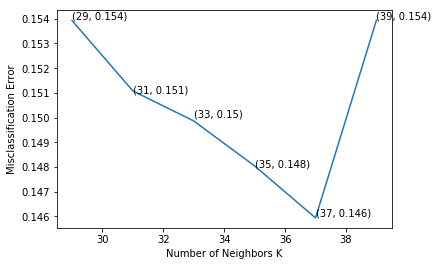


The Accuracy of the knn classifier for k = 37 is 84.84944331983806 %

Confusion Matrix :-
[[  237  2986]
 [   51 20726]]

TPR: 87.40721997300945 %
TNR: 82.29166666666666 %
FPR: 17.708333333333336 %
FNR: 12.592780026990551 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.82      0.07      0.14      3223
          1       0.87      1.00      0.93     20777

avg / total       0.87      0.87      0.82     24000

Wall time: 4min 47s


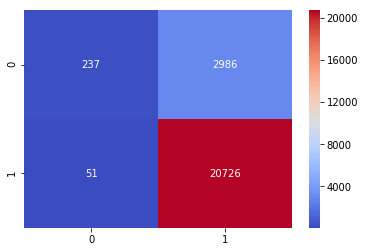

In [16]:
%%time
# Brute Force Algo
info = run_KNN(data_train, bow_counts_train, data_test, bow_counts_test, start_k=29, end_k=40)
save_model_info("BOW (Brute Force)", info)
pt.add_row(["BOW (Brute Force)"] + info)

In [20]:
%%time
cv_model = CountVectorizer(max_features=2000, min_df=50)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 2000) (24000, 2000)
Wall time: 2.84 s


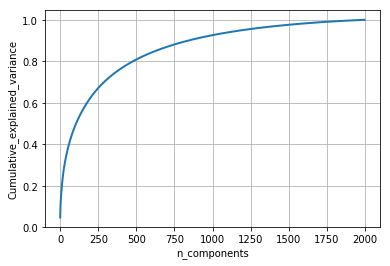

Wall time: 1min 25s


In [21]:
%%time
svd = TruncatedSVD(n_components=1999, n_iter=3, random_state=42)
dim_red_train = svd.fit_transform(bow_counts_train)
cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the Truncated SVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [22]:
%%time
# print(list(enumerate(sorted(cum_var_explained, reverse=True))))
# From the list obtained, n_components=750 Explains ~ 90% of Variance.
svd = TruncatedSVD(n_components=750, n_iter=3, random_state=42)
dim_red_train = svd.fit_transform(bow_counts_train)
dim_red_test = svd.transform(bow_counts_test)
print(dim_red_train.shape, dim_red_test.shape)

(56000, 750) (24000, 750)
Wall time: 22.9 s


(56000, 5) (56000, 750)
X_Train: (56000, 755)
y_Train: (56000,)
X_Test: (24000, 755)
y_Test: (24000,)
25-NN step Ended with Mean Score- 0.7980654613867827...
27-NN step Ended with Mean Score- 0.7947528969032422...
29-NN step Ended with Mean Score- 0.8047694535572486...
31-NN step Ended with Mean Score- 0.8107377377027536...
33-NN step Ended with Mean Score- 0.8121747099136407...
35-NN step Ended with Mean Score- 0.8141835016835017...
37-NN step Ended with Mean Score- 0.8225739336691713...

The optimal number of neighbors is 37 with Mean Error of 0.1774260663308287.


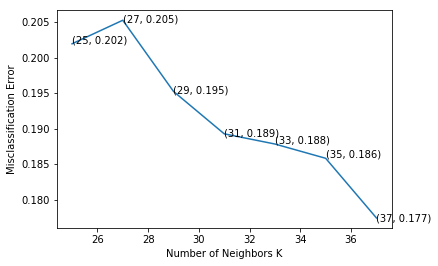


The Accuracy of the knn classifier for k = 37 is 83.5021284540017 %

Confusion Matrix :-
[[  238  2985]
 [   61 20716]]

TPR: 87.40559470064554 %
TNR: 79.59866220735786 %
FPR: 20.401337792642142 %
FNR: 12.594405299354458 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.80      0.07      0.14      3223
          1       0.87      1.00      0.93     20777

avg / total       0.86      0.87      0.82     24000

Wall time: 2h 36min 42s


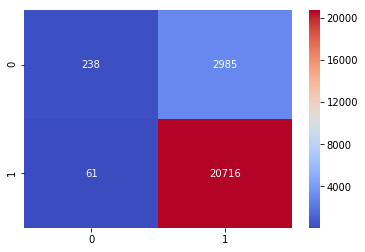

In [25]:
%%time
# KD-Tree Force Algo
info = run_KNN(data_train, dim_red_train, data_test, dim_red_test, \
               alg="kd_tree", start_k=25, end_k=38, k_metric='minkowski', dense_matrix=True)
save_model_info("BOW (KD_Tree)", info)
pt.add_row(["BOW (KD_Tree)"] + info)

In [26]:
print(pt)

+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
| Text Vectorizer Model | Optimal K-value |  Scoring Metric | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
|   BOW (Brute Force)   |        37       | precision_macro |  84.85   | 87.41 | 82.29 | 17.71 | 12.59 |
|     BOW (KD_Tree)     |        37       | precision_macro |   83.5   | 87.41 |  79.6 |  20.4 | 12.59 |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+


In [27]:
del cv_model, bow_counts_train, bow_counts_test, svd, dim_red_train, dim_red_test

# TFIDF model with 80k datapoints

In [28]:
%%time
tfidf_model = TfidfVectorizer(max_features=7000, min_df=10)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 6463) (24000, 6463)
Wall time: 2.78 s


In [15]:
sparse.save_npz('./Matrices/tfidf_train.npz', tfidf_train)
sparse.save_npz('./Matrices/tfidf_test.npz', tfidf_test)

(56000, 5) (56000, 6463)
X_Train: (56000, 6468)
y_Train: (56000,)
X_Test: (24000, 6468)
y_Test: (24000,)
17-NN step Ended with Mean Score- 0.8793403444707073...
19-NN step Ended with Mean Score- 0.8813683448562982...
21-NN step Ended with Mean Score- 0.8965530868256658...
23-NN step Ended with Mean Score- 0.8948537800996818...
25-NN step Ended with Mean Score- 0.8976221285934638...
27-NN step Ended with Mean Score- 0.8947920367298323...

The optimal number of neighbors is 25 with Mean Error of 0.1023778714065362.


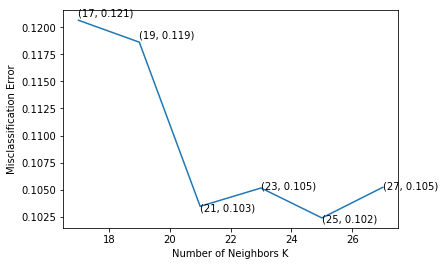


The Accuracy of the knn classifier for k = 25 is 88.74656797263253 %

Confusion Matrix :-
[[  236  2987]
 [   26 20751]]

TPR: 87.41680006740248 %
TNR: 90.07633587786259 %
FPR: 9.923664122137405 %
FNR: 12.583199932597521 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.90      0.07      0.14      3223
          1       0.87      1.00      0.93     20777

avg / total       0.88      0.87      0.83     24000

Wall time: 5min 20s


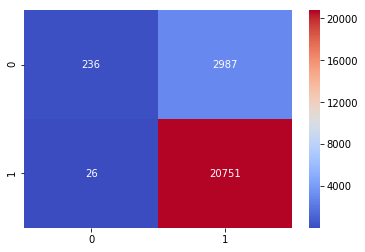

In [29]:
%%time
# Brute Force Algo
info = run_KNN(data_train, tfidf_train, data_test, tfidf_test, start_k=17, end_k=28)
save_model_info("TFIDF (Brute Force)", info)
pt.add_row(["TFIDF (Brute Force)"] + info)

In [31]:
%%time
tfidf_model = TfidfVectorizer(max_features=2000, min_df=50)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 2000) (24000, 2000)
Wall time: 3.39 s


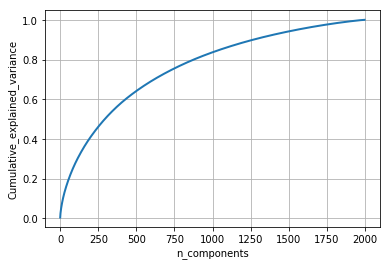

In [32]:
svd = TruncatedSVD(n_components=1999, n_iter=3, random_state=42)
dim_red_train = svd.fit_transform(tfidf_train)
cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the Truncated SVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [33]:
%%time
# print(list(enumerate(sorted(cum_var_explained, reverse=True))))
# From the list obtained, n_components=1250 Explains ~ 90% of Variance.
svd = TruncatedSVD(n_components=1250, n_iter=3, random_state=42)
dim_red_train = svd.fit_transform(tfidf_train)
dim_red_test = svd.transform(tfidf_test)
print(dim_red_train.shape, dim_red_test.shape)

(56000, 1250) (24000, 1250)
Wall time: 46 s


(56000, 5) (56000, 1250)
X_Train: (56000, 1255)
y_Train: (56000,)
X_Test: (24000, 1255)
y_Test: (24000,)
21-NN step Ended with Mean Score- 0.8797730547550433...
23-NN step Ended with Mean Score- 0.886127534653625...
25-NN step Ended with Mean Score- 0.8907909482585594...
27-NN step Ended with Mean Score- 0.8918165467625899...
29-NN step Ended with Mean Score- 0.8994506410034971...

The optimal number of neighbors is 29 with Mean Error of 0.10054935899650286.


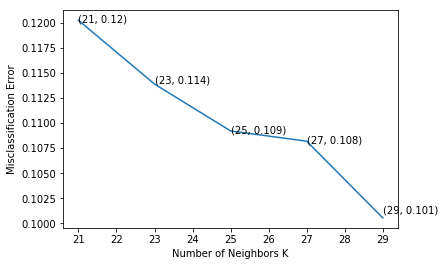


The Accuracy of the knn classifier for k = 29 is 89.15011056787789 %

Confusion Matrix :-
[[  193  3030]
 [   19 20758]]

TPR: 87.26248528669917 %
TNR: 91.0377358490566 %
FPR: 8.962264150943396 %
FNR: 12.737514713300824 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.91      0.06      0.11      3223
          1       0.87      1.00      0.93     20777

avg / total       0.88      0.87      0.82     24000

Wall time: 1h 15min 4s


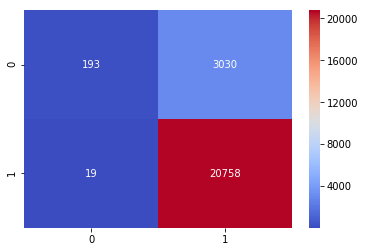

In [34]:
%%time
# KD-Tree Force Algo
info = run_KNN(data_train, dim_red_train, data_test, dim_red_test, \
               alg="kd_tree", start_k=21, end_k=30, k_metric='minkowski', dense_matrix=True)
save_model_info("TFIDF (KD_Tree)", info)
pt.add_row(["TFIDF (KD_Tree)"] + info)

In [35]:
print(pt)

+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
| Text Vectorizer Model | Optimal K-value |  Scoring Metric | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
|   BOW (Brute Force)   |        37       | precision_macro |  84.85   | 87.41 | 82.29 | 17.71 | 12.59 |
|     BOW (KD_Tree)     |        37       | precision_macro |   83.5   | 87.41 |  79.6 |  20.4 | 12.59 |
|  TFIDF (Brute Force)  |        25       | precision_macro |  88.75   | 87.42 | 90.08 |  9.92 | 12.58 |
|    TFIDF (KD_Tree)    |        29       | precision_macro |  89.15   | 87.26 | 91.04 |  8.96 | 12.74 |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+


In [36]:
del tfidf_model, tfidf_train, tfidf_test, svd, dim_red_train, dim_red_test

# Average W2V model with 80k datapoints

In [37]:
%%time
def avg_w2v(data_train, data_test):
    # Process Train Data
    train_list_of_sent=[]
    for sent in data_train['CleanedText'].values:
        train_list_of_sent.append(sent.split())

    # Build W2V model based on Train Data only
    w2v_model = Word2Vec(train_list_of_sent, min_count=5, size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    sent_vectors_train = []
    for sent in train_list_of_sent:
        sent_vec = np.zeros(50)
        count_words = 0
        for word in sent:
            if word in w2v_words:
                try:
                    vec = w2v_model.wv[word]
                except KeyError:
                    vec = np.zeros(50)
                sent_vec += vec
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors_train.append(sent_vec)

    # Process Test Data
    test_list_of_sent=[]
    for sent in data_test['CleanedText'].values:
        test_list_of_sent.append(sent.split())

    sent_vectors_test = []
    for sent in test_list_of_sent:
        sent_vec = np.zeros(50)
        count_words = 0
        for word in sent:
            if word in w2v_words:
                try:
                    vec = w2v_model.wv[word]      # Use W2V model based on Train data to create the text Vectors.
                except KeyError:
                    vec = np.zeros(50)
                sent_vec += vec
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors_test.append(sent_vec)
    
    return sent_vectors_train, sent_vectors_test

sent_vectors_train, sent_vectors_test = avg_w2v(data_train, data_test)
print(len(sent_vectors_train), len(sent_vectors_test))

56000 24000
Wall time: 1min 30s


In [21]:
pd.DataFrame(sent_vectors_train).to_csv('./Matrices/avg_w2v_train.csv')
pd.DataFrame(sent_vectors_test).to_csv('./Matrices/avg_w2v_test.csv')

(56000, 5) (56000, 50)
X_Train: (56000, 55)
y_Train: (56000,)
X_Test: (24000, 55)
y_Test: (24000,)
39-NN step Ended with Mean Score- 0.8669215457924064...
41-NN step Ended with Mean Score- 0.8734537778265161...
43-NN step Ended with Mean Score- 0.8756630364700775...
45-NN step Ended with Mean Score- 0.878170746510094...
47-NN step Ended with Mean Score- 0.8737461059286732...
49-NN step Ended with Mean Score- 0.8771229238991565...
51-NN step Ended with Mean Score- 0.8740547719925611...
53-NN step Ended with Mean Score- 0.8688377755353324...
55-NN step Ended with Mean Score- 0.8723190351942428...
57-NN step Ended with Mean Score- 0.8764727057804381...

The optimal number of neighbors is 45 with Mean Error of 0.12182925348990603.


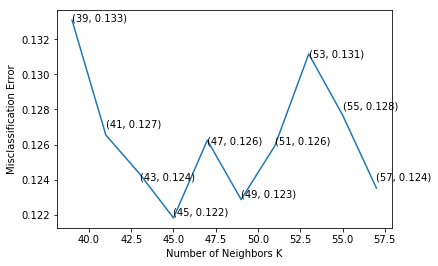


The Accuracy of the knn classifier for k = 45 is 87.37253847556292 %

Confusion Matrix :-
[[  340  2883]
 [   51 20726]]

TPR: 87.78855521199543 %
TNR: 86.95652173913044 %
FPR: 13.043478260869565 %
FNR: 12.211444788004574 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.87      0.11      0.19      3223
          1       0.88      1.00      0.93     20777

avg / total       0.88      0.88      0.83     24000

Wall time: 2min 55s


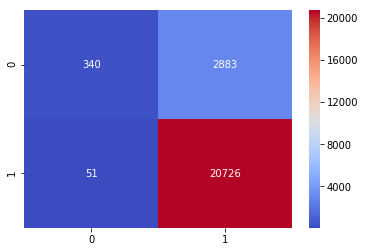

In [40]:
%%time
# Brute Force Algo
info = run_KNN(data_train, np.array(sent_vectors_train), data_test, np.array(sent_vectors_test), \
               start_k=39, end_k=58, dense_matrix=True)
save_model_info("Avg. W2V (Brute Force)", info)
pt.add_row(["Avg. W2V (Brute Force)"] + info)

(56000, 5) (56000, 50)
X_Train: (56000, 55)
y_Train: (56000,)
X_Test: (24000, 55)
y_Test: (24000,)
41-NN step Ended with Mean Score- 0.8707681508223024...
43-NN step Ended with Mean Score- 0.8781383750132645...
45-NN step Ended with Mean Score- 0.8747402281118279...
47-NN step Ended with Mean Score- 0.8699237642429707...
49-NN step Ended with Mean Score- 0.8728324872046489...
51-NN step Ended with Mean Score- 0.8761737773165383...

The optimal number of neighbors is 43 with Mean Error of 0.12186162498673547.


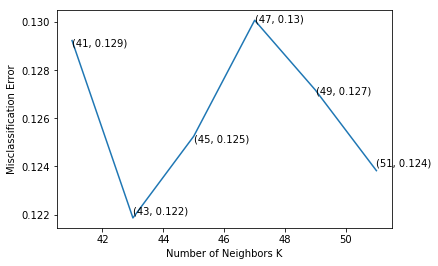


The Accuracy of the knn classifier for k = 43 is 87.79648240239686 %

Confusion Matrix :-
[[  319  2904]
 [   44 20733]]

TPR: 87.71417692600583 %
TNR: 87.87878787878788 %
FPR: 12.121212121212121 %
FNR: 12.285823073994163 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.88      0.10      0.18      3223
          1       0.88      1.00      0.93     20777

avg / total       0.88      0.88      0.83     24000

Wall time: 12min 27s


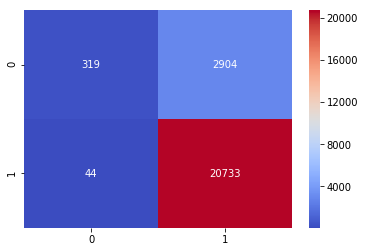

In [44]:
%%time
# KD-Tree Force Algo
info = run_KNN(data_train, np.array(sent_vectors_train), data_test, np.array(sent_vectors_test), \
               alg="kd_tree", start_k=41, end_k=52, k_metric='minkowski', dense_matrix=True)
save_model_info("Avg. W2V (KD_Tree)", info)
pt.add_row(["Avg. W2V (KD_Tree)"] + info)

In [45]:
print(pt)

+------------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
| Text Vectorizer Model  | Optimal K-value |  Scoring Metric | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+------------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
|   BOW (Brute Force)    |        37       | precision_macro |  84.85   | 87.41 | 82.29 | 17.71 | 12.59 |
|     BOW (KD_Tree)      |        37       | precision_macro |   83.5   | 87.41 |  79.6 |  20.4 | 12.59 |
|  TFIDF (Brute Force)   |        25       | precision_macro |  88.75   | 87.42 | 90.08 |  9.92 | 12.58 |
|    TFIDF (KD_Tree)     |        29       | precision_macro |  89.15   | 87.26 | 91.04 |  8.96 | 12.74 |
| Avg. W2V (Brute Force) |        45       | precision_macro |  87.37   | 87.79 | 86.96 | 13.04 | 12.21 |
|   Avg. W2V (KD_Tree)   |        43       | precision_macro |   87.8   | 87.71 | 87.88 | 12.12 | 12.29 |
+------------------------+-----------------+--

# TFIDF-weighted W2V model with 80k datapoints

In [46]:
%%time
def tfidf_w2v(data_train, data_test):
    tfidf = TfidfVectorizer()
    tfidf_vect_train = tfidf.fit_transform(data_train['CleanedText'].values).toarray()
    tfidf_vect_test = tfidf.transform(data_test['CleanedText'].values).toarray()
    words_dict = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

    # Process Train Data
    list_of_sent=[]
    for sent in data_train['CleanedText'].values:
        list_of_sent.append(sent.split())

    # Build W2V model based on Train Data only
    w2v_model = Word2Vec(list_of_sent, min_count=5, size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    tfidf_sent_vectors_train = []
    row=0
    for sent in list_of_sent:
        sent_vec = np.zeros(50)
        weighted_sum = 0
        for word in sent:
            if word in w2v_words:
                try:
                    vec = w2v_model.wv[word]
                except KeyError:
                    vec = np.ones(50)
                tf_idf = words_dict[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weighted_sum += tf_idf
        if weighted_sum != 0:
            sent_vec /= weighted_sum
        tfidf_sent_vectors_train.append(sent_vec)
        row += 1

    # Process Test Data
    list_of_sent=[]
    for sent in data_test['CleanedText'].values:
        list_of_sent.append(sent.split())

    tfidf_sent_vectors_test = []
    row=0
    for sent in list_of_sent:
        sent_vec = np.zeros(50)
        weighted_sum = 0
        for word in sent:
            if word in w2v_words:
                try:
                    vec = w2v_model.wv[word]       # Use W2V model based on Train data to create the text Vectors.
                except KeyError:
                    vec = np.ones(50)
                tf_idf = words_dict[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weighted_sum += tf_idf
        if weighted_sum != 0:
            sent_vec /= weighted_sum
        tfidf_sent_vectors_test.append(sent_vec)
        row += 1
    
    return tfidf_sent_vectors_train, tfidf_sent_vectors_test

tfidf_sent_vectors_train, tfidf_sent_vectors_test = tfidf_w2v(data_train, data_test)
print(len(tfidf_sent_vectors_train), len(tfidf_sent_vectors_test))

56000 24000
Wall time: 1min 46s


In [26]:
pd.DataFrame(tfidf_sent_vectors_train).to_csv('./Matrices/tfidf_w2v_train.csv')
pd.DataFrame(tfidf_sent_vectors_test).to_csv('./Matrices/tfidf_w2v_test.csv')

(56000, 5) (56000, 50)
X_Train: (56000, 55)
y_Train: (56000,)
X_Test: (24000, 55)
y_Test: (24000,)
29-NN step Ended with Mean Score- 0.8490099319002979...
31-NN step Ended with Mean Score- 0.841988598642591...
33-NN step Ended with Mean Score- 0.847671332046332...
35-NN step Ended with Mean Score- 0.8538605993876001...
37-NN step Ended with Mean Score- 0.8516620158220184...

The optimal number of neighbors is 35 with Mean Error of 0.14613940061239994.


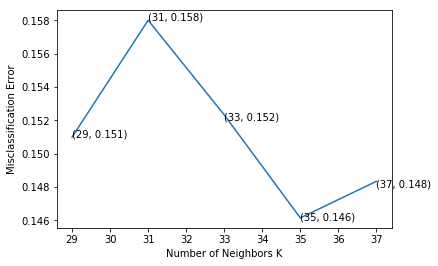


The Accuracy of the knn classifier for k = 35 is 85.41447242055628 %

Confusion Matrix :-
[[  288  2935]
 [   58 20719]]

TPR: 87.59195062145938 %
TNR: 83.23699421965318 %
FPR: 16.76300578034682 %
FNR: 12.408049378540627 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.83      0.09      0.16      3223
          1       0.88      1.00      0.93     20777

avg / total       0.87      0.88      0.83     24000

Wall time: 1min 43s


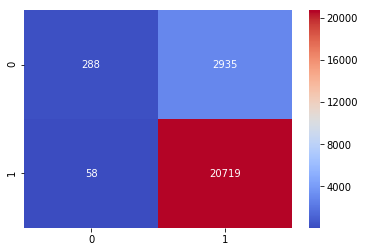

In [50]:
%%time
# Brute Force Algo
info = run_KNN(data_train, np.array(tfidf_sent_vectors_train), data_test, np.array(tfidf_sent_vectors_test), \
               start_k=29, end_k=38, dense_matrix=True)
save_model_info("TFIDF W2V (Brute Force)", info)
pt.add_row(["TFIDF W2V (Brute Force)"] + info)

(56000, 5) (56000, 50)
X_Train: (56000, 55)
y_Train: (56000,)
X_Test: (24000, 55)
y_Test: (24000,)
29-NN step Ended with Mean Score- 0.853723841205033...
31-NN step Ended with Mean Score- 0.8594069529652352...
33-NN step Ended with Mean Score- 0.8607426838265431...
35-NN step Ended with Mean Score- 0.8534905014361146...
37-NN step Ended with Mean Score- 0.8580528846153846...

The optimal number of neighbors is 33 with Mean Error of 0.13925731617345694.


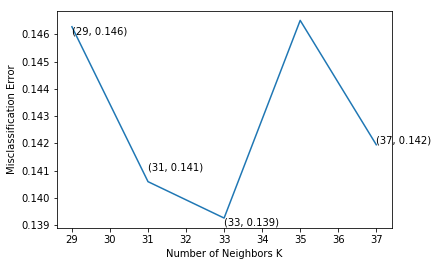


The Accuracy of the knn classifier for k = 33 is 86.7301101529827 %

Confusion Matrix :-
[[  246  2977]
 [   40 20737]]

TPR: 87.44623429197942 %
TNR: 86.01398601398601 %
FPR: 13.986013986013987 %
FNR: 12.553765708020578 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.86      0.08      0.14      3223
          1       0.87      1.00      0.93     20777

avg / total       0.87      0.87      0.83     24000

Wall time: 11min 21s


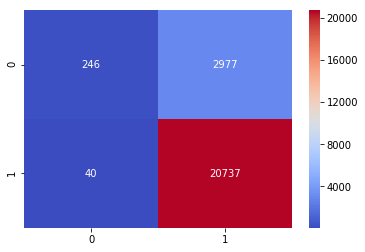

In [47]:
%%time
# KD-Tree Force Algo
info = run_KNN(data_train, np.array(tfidf_sent_vectors_train), data_test, np.array(tfidf_sent_vectors_test), \
               alg="kd_tree", start_k=29, end_k=38, k_metric='minkowski', dense_matrix=True)
save_model_info("TFIDF W2V (KD_Tree)", info)
pt.add_row(["TFIDF W2V (KD_Tree)"] + info)

In [51]:
print(pt)

+-------------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
|  Text Vectorizer Model  | Optimal K-value |  Scoring Metric | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
|    BOW (Brute Force)    |        37       | precision_macro |  84.85   | 87.41 | 82.29 | 17.71 | 12.59 |
|      BOW (KD_Tree)      |        37       | precision_macro |   83.5   | 87.41 |  79.6 |  20.4 | 12.59 |
|   TFIDF (Brute Force)   |        25       | precision_macro |  88.75   | 87.42 | 90.08 |  9.92 | 12.58 |
|     TFIDF (KD_Tree)     |        29       | precision_macro |  89.15   | 87.26 | 91.04 |  8.96 | 12.74 |
|  Avg. W2V (Brute Force) |        45       | precision_macro |  87.37   | 87.79 | 86.96 | 13.04 | 12.21 |
|    Avg. W2V (KD_Tree)   |        43       | precision_macro |   87.8   | 87.71 | 87.88 | 12.12 | 12.29 |
|   TFIDF W2V (KD_Tree)   |        33

# Conclusions :-
-  The Dataset being highly imbalanced (8:1) the Scoring metric has been selected based on the Model performance of - high TPR & TNR and low FPR & FNR.
-  Based on the above performance criteria, 'precision_macro' has shown to provide high True Negative Rate (TNR) with low False Positive Rate (FPR).
-  From the Performances obtained on the four Vectorizer models, it has been observed that TFIDF Vectorizer based 29-NN model is giving the best performance - high TPR & TNR and low FPR & FNR.
-  The Model performance might improve if the unbalancedness of the dataset can be treated with Oversampling - repeating Minority class or creating Synthetic datapoints using SMOTE.
-  The KD-Tree implementations are taking a lot more time than the Brute Force counterparts - this might be attributed to the fact that dimensionality of the dataset is quite large.
- Reducing the 'n_components' in the Vectorizer models have proved to increase the True Negative Rate. This might be due to 'Hughes Phenomenon' - for the same data-set size, increasing dimensions results in decrease Performance.